In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from icecube import icetray, dataclasses, dataio, recclasses

# import dictionary
# file provided by Jaun-Carlos (plus printing the keys for easy view)
# Load in the data file (contains SYBILL 2.3d data)
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")

# Load in the SIBYLL2.1 particle sims - note that these will also be your variable names
KEYS = ['energy', 'particle_type', 'hits', 'reco_pass', 'showerplane_zen', 'laputop_zen', 'Hweights', 'Gweights']

year = 2012

model = 'SIBYLL2.1'

for key in KEYS:
    if os.path.isfile(f'/data/user/tfutrell/it_anisotropy/2012/SIBYLL2.1/{key}.npy'):
        with open(f'/data/user/tfutrell/it_anisotropy/2012/SIBYLL2.1/{key}.npy', 'rb') as file:
            globals()[key] = np.load(file)
    else:
        print(f'{key}.npy does not exist or is not in the required folder.')

#print(list(d.keys()))

In [2]:
# set up quality cut for In-Ice data
qual_cut = (d['zenith'] > 0.002) * (d['zenith'] < (np.pi - 0.002)) * (d['nchannel'] >= 10) * (d['mc_energy'] == d['mc_energy']) * (d['rlogl'] < 25)
# set up bin cut
bin_cut = (d['reco_energy'] > 4) * (d['reco_energy'] < 8)

# IceTop Tiers and quality cuts - quality cuts may not work well with some years and Tiers (e.g. reco_succeeded cancels out Tier 4 for 2012)
tier1_quality_cuts = (showerplane_zen < np.radians(55)) * (reco_pass == 1)
quality_cuts = (laputop_zen < np.radians(55)) * (reco_pass == 1)
# Calculation for the Tier offset per year
offset = round((year - 2011)/2)


In [3]:
# functions to calculate Z value per event, save to array, then take the log10 of the array.
#define a function to go from PDG code to Z
def _get_charge(ptype):
    if ptype<1000020040:
        return 1
    else:
        remainder = int(ptype)%1000000000
        remainder -= remainder%1000
        
        return remainder/10000
    
#turn it into a vectorized function (for speed)
get_charge = np.vectorize(_get_charge)

#example of usage
zarray = get_charge(d['type'])

# create log10(z) array for later cells
lza = np.log10(zarray)

In [81]:
# set up dictionaries for later cells
BINS={
    '4.125': (d['reco_energy'] > 4) * (d['reco_energy'] < 4.25),
    '4.375': (d['reco_energy'] > 4.25) * (d['reco_energy'] < 4.5),
    '4.625': (d['reco_energy'] > 4.5) * (d['reco_energy'] < 4.75),
    '4.875': (d['reco_energy'] > 4.75) * (d['reco_energy'] < 5),
    '5.125': (d['reco_energy'] > 5) * (d['reco_energy'] < 5.25),
    '5.375': (d['reco_energy'] > 5.25) * (d['reco_energy'] < 5.5),
    '5.75': (d['reco_energy'] > 5.5) * (d['reco_energy'] < 6),
    '6.25': (d['reco_energy'] > 6) * (d['reco_energy'] < 6.5), 
    '7.25': (d['reco_energy'] > 6.5) * (d['reco_energy'] < 8)
}
TIERS = {
    'Tier 1': (3 <= hits) * (hits < 5) * (showerplane_zen < np.radians(55)),
    'Tier 2': (5 <= hits) * (hits < 10 - offset) * quality_cuts,
    'Tier 3': (10 - offset <= hits) * (hits < 14 - offset) * quality_cuts,
    'Tier 4': (14 - offset <= hits) * quality_cuts
}
ITL={
    'Tier 1': '300',
    'Tier 2': '940',
    'Tier 3': '2400',
    'Tier 4': '5300'
}
ITRL={
    'Tier 1': '150',
    'Tier 2': '470',
    'Tier 3': '1200',
    'Tier 4': '2300' 
}
COMP={
    'proton': d['type'] == 2212,
    'helium': d['type'] == 1.00002004e+09,
    'nitrogen': d['type'] == 1.000070140e+09,
    'aluminum': d['type'] == 1.00013027e+09,
    'iron': d['type'] == 1.00026056e+09
}
COMPC={
    'proton': 'red',
    'helium': 'orange',
    'nitrogen': 'darkgreen',
    'aluminum': 'blue',
    'iron': 'purple'
}
COMPL={
    'proton': 'p',
    'helium': 'He',
    'nitrogen': 'N',
    'aluminum': 'Al',
    'iron': 'Fe'
}
BINL = {
    '4.125': '13',
    '4.375': '24',
    '4.625': '42',
    '4.875': '67',
    '5.125': '130',
    '5.375': '240',
    '5.75':'470',
    '6.25':'1500', 
    '7.25':'5300'
}
BINRL = {
    '4.125': '13',
    '4.375': '22',
    '4.625': '39',
    '4.875': '66',
    '5.125': '121',
    '5.375': '213',
    '5.75':'420',
    '6.25':'1250', 
    '7.25':'4420'
}
Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'oxygen': 8,
    'aluminum': 13,
    'iron': 26
}
# Cuts for different compositions
COMPS = {
    'proton': particle_type == 2.21200000e+03,
    'helium' : particle_type == 1.00002004e+09,
    'oxygen': particle_type == 1.00008016e+09,
    'iron': particle_type == 1.00026056e+09,
    'true': np.tile(True, len(energy))
}
# Graph colors by composition
COLORS = {
    'true' : 'black',
    'proton': 'red',
    'helium': 'orange',
    'oxygen': 'blue',    
    'iron': 'purple'
}
# Graph labels by composition
LABEL = {
    'true' : 'Data',
    'proton': 'p',
    'helium': 'He',
    'oxygen': 'O',
    'iron': 'Fe'
}

# set up compositional cuts to separate data by composition
pcut = d['type'] == 2212
Hecut = d['type'] == 1.00002004e+09
Ncut = d['type'] == 1.000070140e+09
Alcut = d['type'] == 1.00013027e+09
Fecut =  d['type'] == 1.00026056e+09

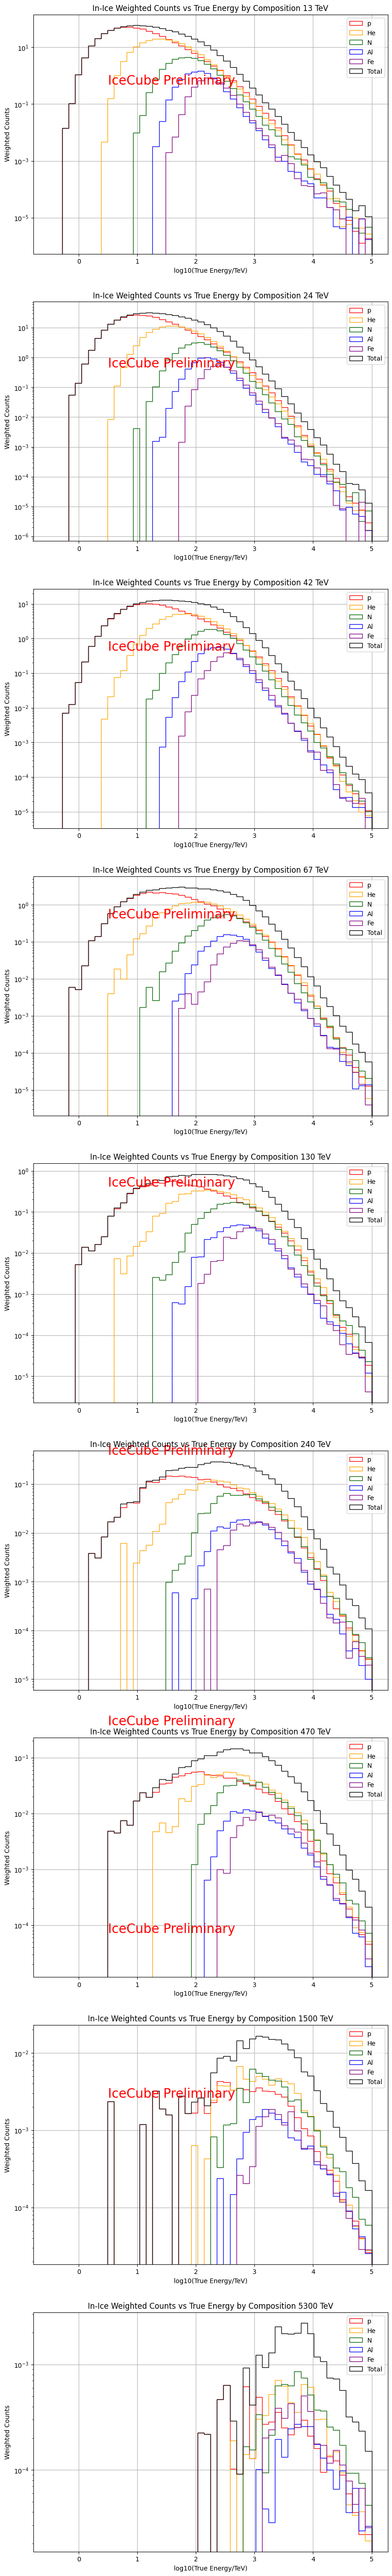

In [104]:
# Cell to plot compositional energy distributions for each energy bin for In-Ice
ncols = 1
nrows = 9
fig, axs = plt.subplots(figsize = (10 * ncols, 8 * nrows), nrows=nrows)
bins=np.linspace(-0.5, 5, 51)
k = 0
for i in BINS:
    for comp in COMP:
        comp_frac = len(d['mc_energy'][BINS[i] * COMP[comp] * qual_cut]) / len(d['mc_energy'][BINS[i] * qual_cut])
        [comp_G_i, bin_comp_i, p_comp_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * COMP[comp] * qual_cut]) - 3, bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * COMP[comp] * qual_cut], color = COMPC[comp], histtype = 'step', label = COMPL[comp], density=False)
    [TG_i, bintg_i, ptg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * qual_cut]) - 3, bins = bins, log = True, weights = d['GlobalSplineFit5Comp'][BINS[i] * qual_cut], color = 'black', histtype = 'step', label = 'Total', density=False)
    axs[k].set_xlabel('log10(True Energy/TeV)')
    axs[k].set_ylabel('Weighted Counts')
    axs[k].set_title('In-Ice Weighted Counts vs True Energy by Composition ' + BINL[i] + ' TeV')
    axs[k].text(.5, .5-(k*.02), 'IceCube Preliminary', color='red', fontsize = 20)
    #axs[k].set_ylim(1e-5, 1e2)
    axs[k].legend()
    axs[k].grid()
    k += 1
    #break

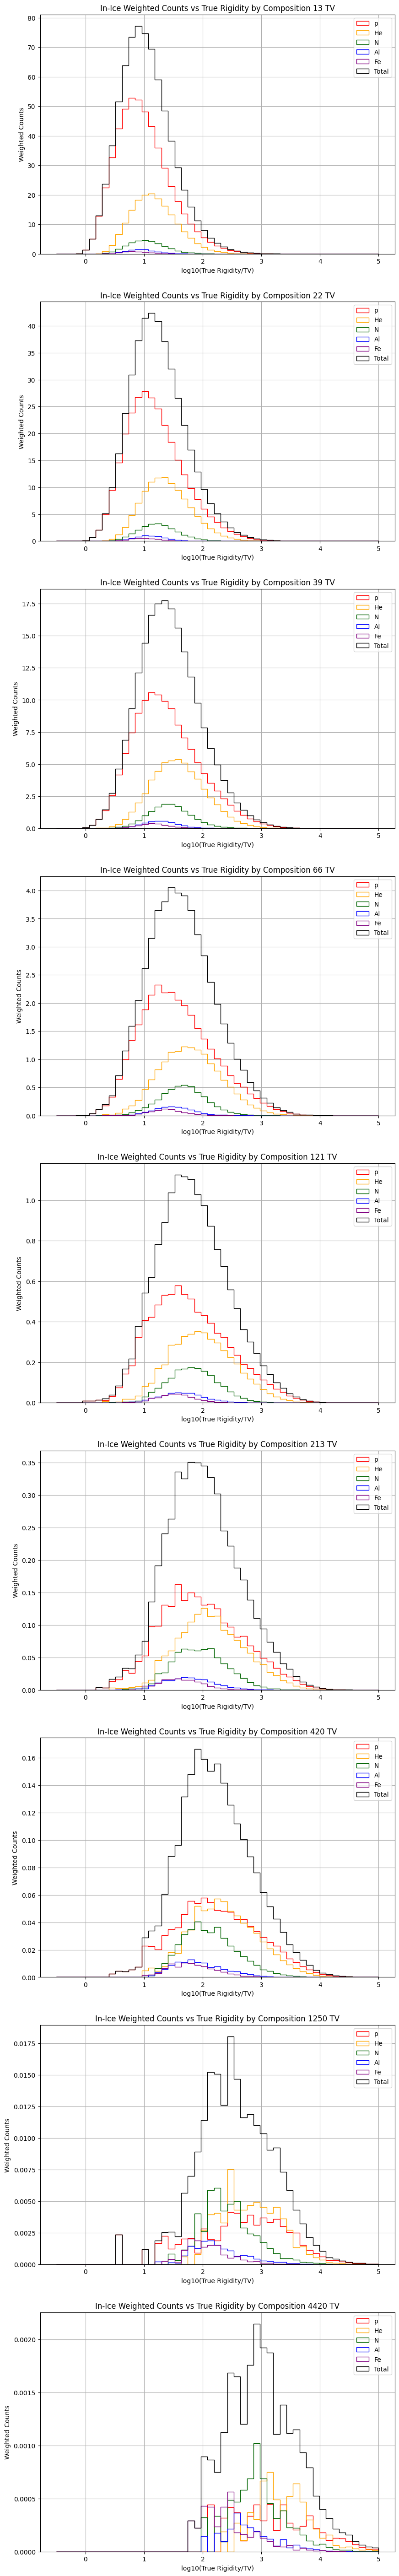

In [87]:
# Cell to plot compositional rigidity distributions for each energy bin for In-Ice
ic_rigidity = np.log10(d['mc_energy']) - 3
for comp, comp_cut in COMP.items():
    ic_rigidity[comp_cut] -= np.log10(Z[comp])
ncols = 1
nrows = 9
fig, axs = plt.subplots(figsize = (10 * ncols, 8 * nrows), nrows=nrows)
bins=np.linspace(-0.5, 5, 50)
k = 0
for i in BINS:
    for comp in COMP:
        [comp_G_i, comp_bin_i, p_comp_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * COMP[comp] * qual_cut] / Z[comp])-3, bins = bins, log = False, weights=d['GlobalSplineFit5Comp'][BINS[i] * COMP[comp] * qual_cut], color = COMPC[comp], histtype = 'step', label = COMPL[comp], density=False)
    [TG_i, bintg_i, ptg_i] = axs[k].hist(ic_rigidity[BINS[i] * qual_cut], bins = bins, log=False, weights = d['GlobalSplineFit5Comp'][BINS[i] * qual_cut], color = 'black', histtype = 'step', label = 'Total', density=False)
    axs[k].set_xlabel('log10(True Rigidity/TV)')
    axs[k].set_ylabel('Weighted Counts')
    axs[k].set_title('In-Ice Weighted Counts vs True Rigidity by Composition ' + BINRL[i] + ' TV')
    #axs[k].set_ylim(1e-5, 1e2)
    axs[k].legend()
    axs[k].grid()
    k += 1


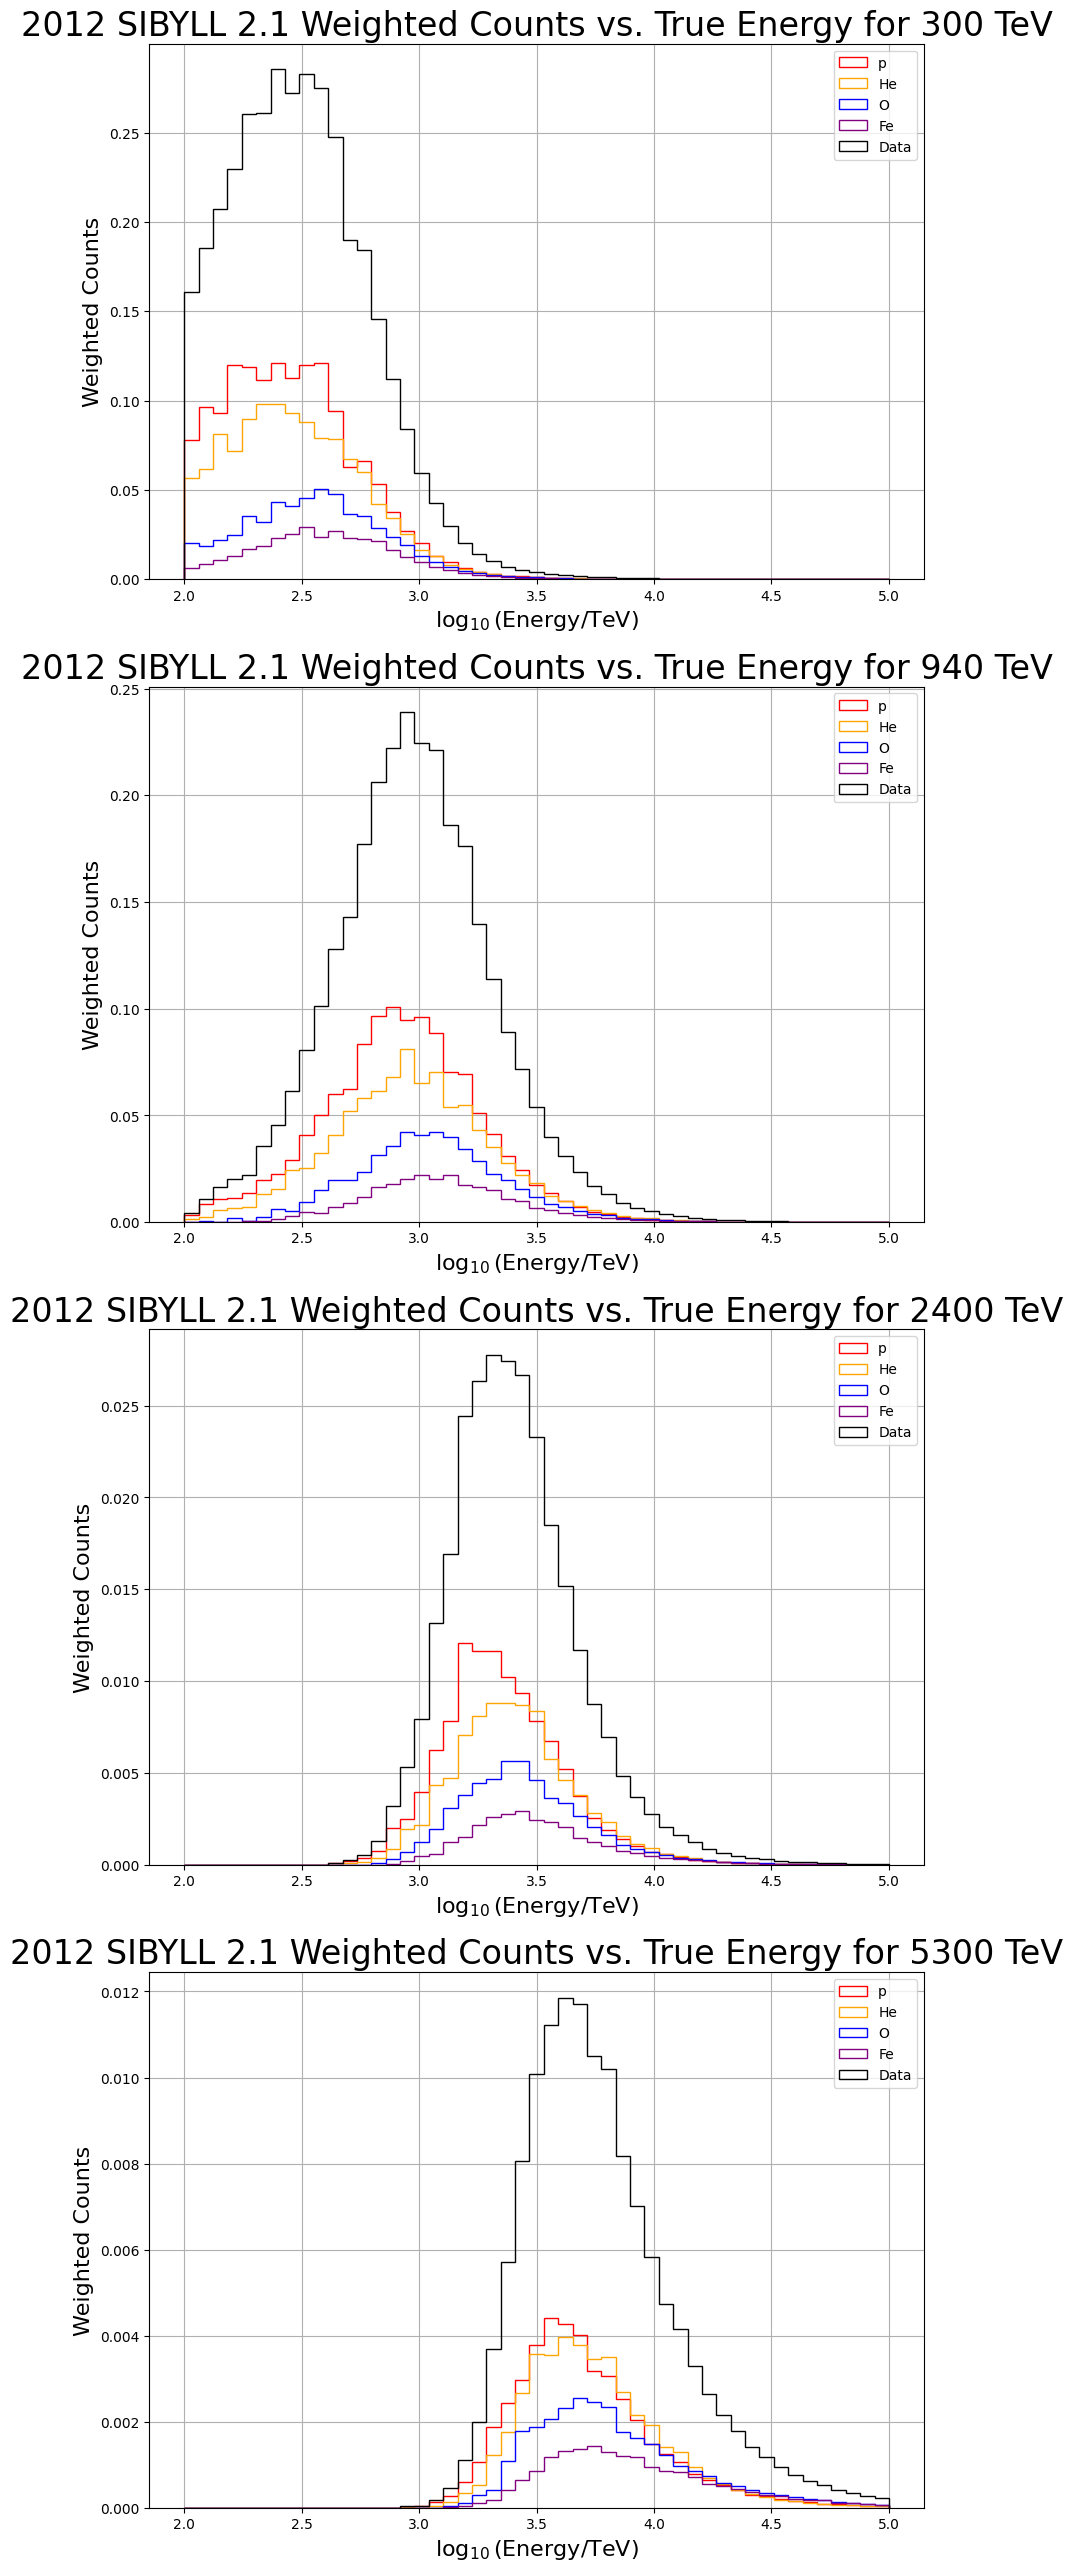

In [7]:
# Cell to plot compositional energy distributions for each energy bin for IceTop
nrows = 4
fig, axs = plt.subplots(figsize=(10, 8 * nrows), nrows=nrows)
bins=np.linspace(2, 5, 50)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for comp, comp_cut in COMPS.items():
        # Set up the histogram arguments
        hist_args = {
            'bins': bins,
            'log': False,
            'label': LABEL[comp],
            'histtype':'step',
            'color': COLORS[comp]
        }

        # Graph rate vs. rigidity
        combined_cut = tier_cut * comp_cut
        # Graph primary energy
        [IT_comp_tier, IT_bins_tier, ITP_comp_tier] = ax.hist(np.log10(energy[combined_cut]) - 3, weights=Gweights[combined_cut], **hist_args)

        #ax.scatter(weighted_quantiles(rigidity[combined_cut], weights=weights[combined_cut]), np.median(rate[0]), label=f'Median {comp} ({weight_name})', c=COLORS[comp])

    ax.set_xlabel('$\log_{{10}}$(Energy/TeV)', size=16)
    ax.set_ylabel('Weighted Counts', size=16)
    ax.set_title(f'2012 SIBYLL 2.1 Weighted Counts vs. True Energy for ' + ITL[tier] + ' TeV', size=24)
    ax.grid()
    ax.legend()

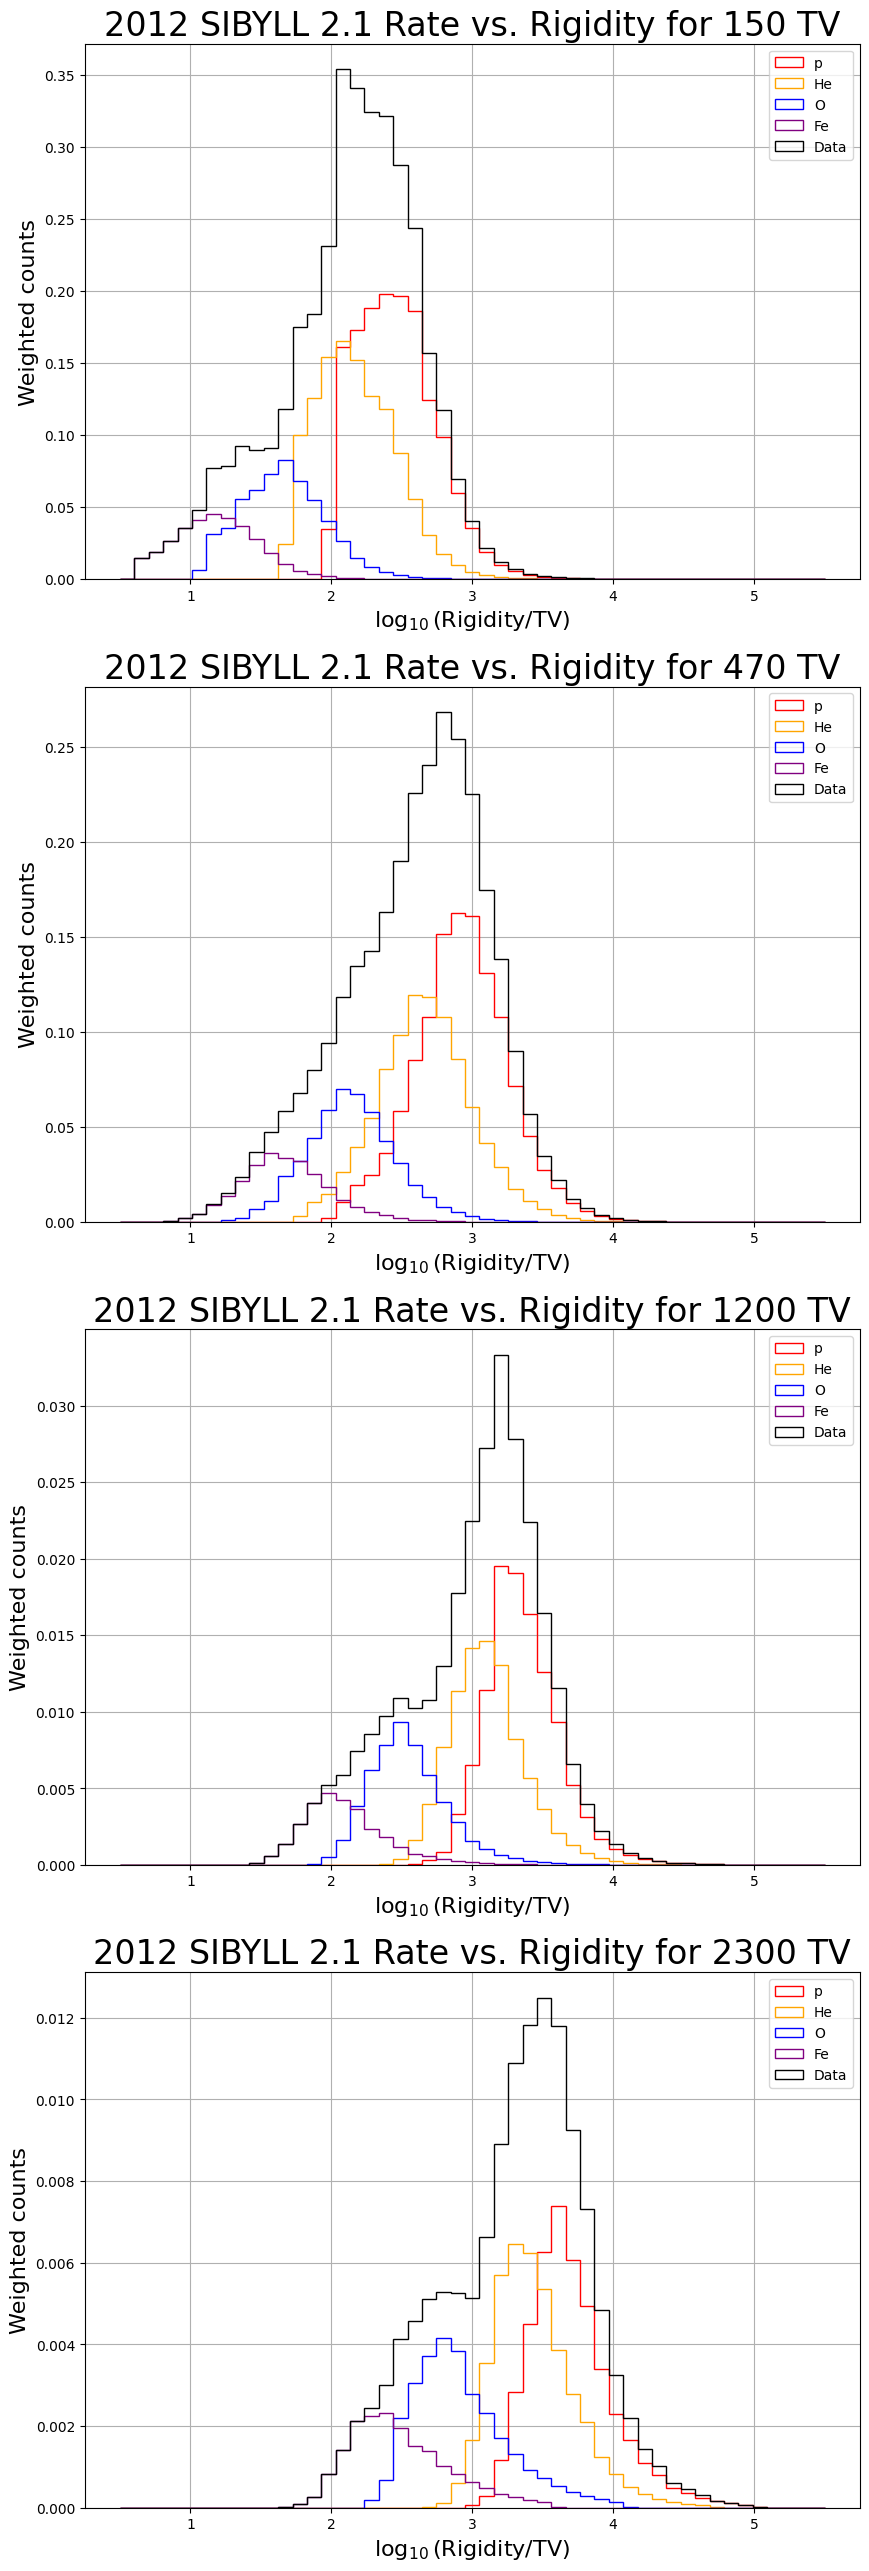

In [8]:
# Cell to plot compositional rigidity distributions for each energy bin for IceTop
nrows = 4
fig, axs = plt.subplots(figsize=(10, 8 * nrows), nrows=nrows)
bins=np.linspace(0.5, 5.5, 50)

# Calculate log10(rigidity)
# The -3 is to scale energy to TeV
rigidity = np.log10(energy) - 3

for comp, comp_cut in COMPS.items():
    if not comp == 'true':
        rigidity[comp_cut] -= np.log10(Z[comp])

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for comp, comp_cut in COMPS.items():
        # Set up the histogram arguments
        hist_args = {
            'bins': bins,
            'log': False,
            'label': LABEL[comp],
            'histtype':'step',
            'color': COLORS[comp]
        }

        # Graph rate vs. rigidity
        combined_cut = tier_cut * comp_cut
        ax.hist(rigidity[combined_cut], weights=Gweights[combined_cut], **hist_args)
        #ax.scatter(weighted_quantiles(rigidity[combined_cut], weights=weights[combined_cut]), np.median(rate[0]), label=f'Median {comp} ({weight_name})', c=COLORS[comp])

    ax.set_xlabel('$\log_{{10}}$(Rigidity/TV)', size=16)
    ax.set_ylabel('Weighted counts', size=16)
    ax.set_title(f'2012 SIBYLL 2.1 Rate vs. Rigidity for ' + ITRL[tier] + ' TV', size=24)
    ax.grid()
    ax.legend()